In [1]:
!pip install transformers==3.4.0

     |████████████████████████████████| 1.3 MB 404 kB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 3.5 MB/s eta 0:00:01
ERROR: allennlp 1.0.0 has requirement transformers<2.12,>=2.9, but you'll have transformers 3.4.0 which is incompatible.
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.7.0
    Uninstalling tokenizers-0.7.0:
      Successfully uninstalled tokenizers-0.7.0
  Attempting uninstall: transformers
    Found existing installation: transformers 2.11.0
    Uninstalling transformers-2.11.0:
      Successfully uninstalled transformers-2.11.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.layers.core import Dense, Dropout
import transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast, RobertaTokenizer, RobertaModel, TFXLMRobertaModel
from transformers import AutoTokenizer,TFXLMRobertaModel, XLMRobertaModel,XLMTokenizer,XLMWithLMHeadModel
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
import matplotlib.pyplot as plt
import numpy as np

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
transformers.__version__

'3.4.0'

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.0.0.2:8470


In [5]:
train = pd.read_csv('../input/modified/train_modified.csv')
valid = pd.read_csv('../input/modified/val_modified.csv')
test = pd.read_csv('../input/modified/test_modified.csv')

In [6]:
xtrain, ytrain = train.Comment.values, train.Emotion.values
xvalid, yvalid = valid.Comment.values, valid.Emotion.values
xtest, ytest = test.Comment.values, test.Emotion.values

In [7]:
tokenizer = AutoTokenizer.from_pretrained("jplu/tf-xlm-roberta-base")
# tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-tlm-xnli15-1024')
max_len = 200

In [8]:
xtrain_pad = tokenizer(
    text=train['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

xvalid_pad = tokenizer(
    text=valid['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

In [9]:
def build_model(transformer):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    sequence_output = transformer(input_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(4, activation='softmax')(cls_token)

    model = Model(inputs=input_ids, outputs=out)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(Adam(lr=1e-5, beta_2 = 0.5), loss=loss, metrics=['accuracy'])

    return model

In [10]:
with strategy.scope():
    transformer_model = TFXLMRobertaModel.from_pretrained("jplu/tf-xlm-roberta-base")
    model = build_model(transformer_model)

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
tfxlm_roberta_model (TFXLMRo ((None, 200, 768), (None, 278043648 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 3076      
Total params: 278,046,724
Trainable params: 278,046,724
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Batch Size 32
history = model.fit(xtrain_pad['input_ids'], ytrain,epochs=100, validation_data= (xvalid_pad['input_ids'], yvalid), batch_size=32)

Epoch 1/100


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 192001536 elements. This may consume a large amount of memory.
  num_elements)


94/94 [==============================] - ETA: 0s - loss: 1.3682 - accuracy: 0.31 - ETA: 5s - loss: 1.3635 - accuracy: 0.32 - ETA: 6s - loss: 1.3723 - accuracy: 0.32 - ETA: 7s - loss: 1.3943 - accuracy: 0.27 - ETA: 7s - loss: 1.4015 - accuracy: 0.26 - ETA: 7s - loss: 1.3965 - accuracy: 0.27 - ETA: 8s - loss: 1.3986 - accuracy: 0.26 - ETA: 8s - loss: 1.4000 - accuracy: 0.26 - ETA: 8s - loss: 1.3970 - accuracy: 0.27 - ETA: 8s - loss: 1.4009 - accuracy: 0.26 - ETA: 8s - loss: 1.4006 - accuracy: 0.25 - ETA: 8s - loss: 1.3993 - accuracy: 0.25 - ETA: 8s - loss: 1.3917 - accuracy: 0.26 - ETA: 7s - loss: 1.3936 - accuracy: 0.25 - ETA: 7s - loss: 1.3946 - accuracy: 0.25 - ETA: 7s - loss: 1.3938 - accuracy: 0.25 - ETA: 7s - loss: 1.3950 - accuracy: 0.25 - ETA: 7s - loss: 1.3936 - accuracy: 0.25 - ETA: 7s - loss: 1.3951 - accuracy: 0.25 - ETA: 7s - loss: 1.3950 - accuracy: 0.25 - ETA: 7s - loss: 1.3961 - accuracy: 0.25 - ETA: 7s - loss: 1.3967 - accuracy: 0.25 - ETA: 7s - loss: 1.3964 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3867 - accuracy: 0.21 - ETA: 4s - loss: 1.3769 - accuracy: 0.29 - ETA: 6s - loss: 1.3855 - accuracy: 0.26 - ETA: 7s - loss: 1.3848 - accuracy: 0.26 - ETA: 7s - loss: 1.3836 - accuracy: 0.26 - ETA: 7s - loss: 1.3872 - accuracy: 0.26 - ETA: 7s - loss: 1.3841 - accuracy: 0.26 - ETA: 7s - loss: 1.3901 - accuracy: 0.25 - ETA: 7s - loss: 1.3988 - accuracy: 0.22 - ETA: 7s - loss: 1.3966 - accuracy: 0.25 - ETA: 7s - loss: 1.4022 - accuracy: 0.24 - ETA: 8s - loss: 1.4004 - accuracy: 0.23 - ETA: 8s - loss: 1.3986 - accuracy: 0.23 - ETA: 8s - loss: 1.3985 - accuracy: 0.23 - ETA: 8s - loss: 1.4010 - accuracy: 0.23 - ETA: 8s - loss: 1.3988 - accuracy: 0.24 - ETA: 8s - loss: 1.3978 - accuracy: 0.24 - ETA: 7s - loss: 1.3981 - accuracy: 0.24 - ETA: 7s - loss: 1.3986 - accuracy: 0.24 - ETA: 7s - loss: 1.3959 - accuracy: 0.25 - ETA: 7s - loss: 1.3941 - accuracy: 0.25 - ETA: 7s - loss: 1.3931 - accuracy: 0.26 - ETA: 7s - loss: 1.3930 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3564 - accuracy: 0.40 - ETA: 4s - loss: 1.3413 - accuracy: 0.37 - ETA: 6s - loss: 1.3328 - accuracy: 0.40 - ETA: 7s - loss: 1.3349 - accuracy: 0.39 - ETA: 9s - loss: 1.3544 - accuracy: 0.34 - ETA: 9s - loss: 1.3596 - accuracy: 0.33 - ETA: 9s - loss: 1.3616 - accuracy: 0.33 - ETA: 9s - loss: 1.3652 - accuracy: 0.32 - ETA: 9s - loss: 1.3652 - accuracy: 0.31 - ETA: 9s - loss: 1.3573 - accuracy: 0.33 - ETA: 8s - loss: 1.3540 - accuracy: 0.33 - ETA: 8s - loss: 1.3548 - accuracy: 0.33 - ETA: 8s - loss: 1.3575 - accuracy: 0.33 - ETA: 8s - loss: 1.3619 - accuracy: 0.32 - ETA: 8s - loss: 1.3631 - accuracy: 0.32 - ETA: 8s - loss: 1.3629 - accuracy: 0.33 - ETA: 8s - loss: 1.3651 - accuracy: 0.32 - ETA: 8s - loss: 1.3638 - accuracy: 0.32 - ETA: 8s - loss: 1.3620 - accuracy: 0.33 - ETA: 7s - loss: 1.3619 - accuracy: 0.33 - ETA: 7s - loss: 1.3627 - accuracy: 0.33 - ETA: 7s - loss: 1.3630 - accuracy: 0.33 - ETA: 7s - loss: 1.3627 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.2722 - accuracy: 0.43 - ETA: 5s - loss: 1.2177 - accuracy: 0.48 - ETA: 7s - loss: 1.1928 - accuracy: 0.54 - ETA: 7s - loss: 1.1770 - accuracy: 0.55 - ETA: 8s - loss: 1.1722 - accuracy: 0.56 - ETA: 8s - loss: 1.1825 - accuracy: 0.56 - ETA: 8s - loss: 1.1839 - accuracy: 0.56 - ETA: 8s - loss: 1.1910 - accuracy: 0.55 - ETA: 8s - loss: 1.1922 - accuracy: 0.55 - ETA: 8s - loss: 1.2059 - accuracy: 0.54 - ETA: 8s - loss: 1.2110 - accuracy: 0.53 - ETA: 8s - loss: 1.2163 - accuracy: 0.52 - ETA: 8s - loss: 1.2248 - accuracy: 0.51 - ETA: 8s - loss: 1.2298 - accuracy: 0.50 - ETA: 8s - loss: 1.2322 - accuracy: 0.50 - ETA: 8s - loss: 1.2344 - accuracy: 0.49 - ETA: 8s - loss: 1.2408 - accuracy: 0.49 - ETA: 7s - loss: 1.2424 - accuracy: 0.48 - ETA: 7s - loss: 1.2416 - accuracy: 0.49 - ETA: 7s - loss: 1.2406 - accuracy: 0.49 - ETA: 7s - loss: 1.2351 - accuracy: 0.50 - ETA: 7s - loss: 1.2305 - accuracy: 0.50 - ETA: 7s - loss: 1.2324 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.0861 - accuracy: 0.65 - ETA: 5s - loss: 1.0650 - accuracy: 0.68 - ETA: 6s - loss: 1.0389 - accuracy: 0.71 - ETA: 7s - loss: 1.0227 - accuracy: 0.74 - ETA: 7s - loss: 1.0135 - accuracy: 0.75 - ETA: 7s - loss: 1.0278 - accuracy: 0.72 - ETA: 8s - loss: 1.0261 - accuracy: 0.73 - ETA: 8s - loss: 1.0102 - accuracy: 0.74 - ETA: 8s - loss: 1.0247 - accuracy: 0.72 - ETA: 8s - loss: 1.0131 - accuracy: 0.73 - ETA: 8s - loss: 1.0058 - accuracy: 0.74 - ETA: 8s - loss: 1.0131 - accuracy: 0.73 - ETA: 8s - loss: 1.0061 - accuracy: 0.74 - ETA: 7s - loss: 1.0164 - accuracy: 0.72 - ETA: 7s - loss: 1.0074 - accuracy: 0.73 - ETA: 7s - loss: 1.0058 - accuracy: 0.74 - ETA: 7s - loss: 1.0086 - accuracy: 0.73 - ETA: 7s - loss: 1.0047 - accuracy: 0.74 - ETA: 7s - loss: 1.0084 - accuracy: 0.73 - ETA: 7s - loss: 1.0081 - accuracy: 0.73 - ETA: 7s - loss: 1.0046 - accuracy: 0.74 - ETA: 7s - loss: 1.0035 - accuracy: 0.74 - ETA: 7s - loss: 1.0032 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8843 - accuracy: 0.87 - ETA: 5s - loss: 0.9203 - accuracy: 0.82 - ETA: 6s - loss: 0.9144 - accuracy: 0.83 - ETA: 7s - loss: 0.9307 - accuracy: 0.82 - ETA: 7s - loss: 0.9367 - accuracy: 0.81 - ETA: 8s - loss: 0.9492 - accuracy: 0.79 - ETA: 8s - loss: 0.9469 - accuracy: 0.79 - ETA: 8s - loss: 0.9369 - accuracy: 0.80 - ETA: 8s - loss: 0.9317 - accuracy: 0.80 - ETA: 8s - loss: 0.9323 - accuracy: 0.80 - ETA: 8s - loss: 0.9371 - accuracy: 0.80 - ETA: 8s - loss: 0.9484 - accuracy: 0.79 - ETA: 8s - loss: 0.9633 - accuracy: 0.77 - ETA: 8s - loss: 0.9706 - accuracy: 0.77 - ETA: 8s - loss: 0.9804 - accuracy: 0.76 - ETA: 7s - loss: 0.9855 - accuracy: 0.75 - ETA: 7s - loss: 0.9862 - accuracy: 0.75 - ETA: 7s - loss: 0.9841 - accuracy: 0.75 - ETA: 7s - loss: 0.9833 - accuracy: 0.75 - ETA: 7s - loss: 0.9856 - accuracy: 0.75 - ETA: 7s - loss: 0.9851 - accuracy: 0.75 - ETA: 7s - loss: 0.9853 - accuracy: 0.75 - ETA: 7s - loss: 0.9896 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8383 - accuracy: 0.90 - ETA: 4s - loss: 0.8850 - accuracy: 0.85 - ETA: 7s - loss: 0.8977 - accuracy: 0.84 - ETA: 7s - loss: 0.8898 - accuracy: 0.85 - ETA: 8s - loss: 0.8841 - accuracy: 0.85 - ETA: 8s - loss: 0.8961 - accuracy: 0.84 - ETA: 8s - loss: 0.8849 - accuracy: 0.85 - ETA: 8s - loss: 0.8857 - accuracy: 0.85 - ETA: 8s - loss: 0.8893 - accuracy: 0.85 - ETA: 8s - loss: 0.8821 - accuracy: 0.85 - ETA: 8s - loss: 0.8912 - accuracy: 0.84 - ETA: 8s - loss: 0.8949 - accuracy: 0.84 - ETA: 8s - loss: 0.8949 - accuracy: 0.84 - ETA: 8s - loss: 0.8985 - accuracy: 0.84 - ETA: 8s - loss: 0.8982 - accuracy: 0.84 - ETA: 8s - loss: 0.8988 - accuracy: 0.84 - ETA: 8s - loss: 0.8930 - accuracy: 0.85 - ETA: 7s - loss: 0.8896 - accuracy: 0.85 - ETA: 7s - loss: 0.8913 - accuracy: 0.85 - ETA: 7s - loss: 0.8876 - accuracy: 0.85 - ETA: 7s - loss: 0.8880 - accuracy: 0.85 - ETA: 7s - loss: 0.8896 - accuracy: 0.85 - ETA: 7s - loss: 0.8884 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7756 - accuracy: 0.96 - ETA: 4s - loss: 0.8217 - accuracy: 0.92 - ETA: 6s - loss: 0.8325 - accuracy: 0.91 - ETA: 7s - loss: 0.8496 - accuracy: 0.89 - ETA: 7s - loss: 0.8427 - accuracy: 0.90 - ETA: 7s - loss: 0.8471 - accuracy: 0.90 - ETA: 7s - loss: 0.8541 - accuracy: 0.89 - ETA: 7s - loss: 0.8633 - accuracy: 0.88 - ETA: 7s - loss: 0.8756 - accuracy: 0.87 - ETA: 8s - loss: 0.8871 - accuracy: 0.85 - ETA: 8s - loss: 0.8986 - accuracy: 0.84 - ETA: 7s - loss: 0.8959 - accuracy: 0.84 - ETA: 7s - loss: 0.8956 - accuracy: 0.84 - ETA: 7s - loss: 0.8998 - accuracy: 0.84 - ETA: 7s - loss: 0.9010 - accuracy: 0.83 - ETA: 7s - loss: 0.9003 - accuracy: 0.83 - ETA: 7s - loss: 0.9025 - accuracy: 0.83 - ETA: 7s - loss: 0.9026 - accuracy: 0.83 - ETA: 7s - loss: 0.9037 - accuracy: 0.83 - ETA: 7s - loss: 0.9036 - accuracy: 0.83 - ETA: 7s - loss: 0.9023 - accuracy: 0.83 - ETA: 7s - loss: 0.8979 - accuracy: 0.84 - ETA: 7s - loss: 0.8955 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8406 - accuracy: 0.90 - ETA: 4s - loss: 0.8763 - accuracy: 0.87 - ETA: 6s - loss: 0.8449 - accuracy: 0.90 - ETA: 7s - loss: 0.8430 - accuracy: 0.90 - ETA: 7s - loss: 0.8503 - accuracy: 0.90 - ETA: 7s - loss: 0.8685 - accuracy: 0.88 - ETA: 7s - loss: 0.8558 - accuracy: 0.89 - ETA: 8s - loss: 0.8568 - accuracy: 0.89 - ETA: 8s - loss: 0.8625 - accuracy: 0.88 - ETA: 8s - loss: 0.8593 - accuracy: 0.88 - ETA: 8s - loss: 0.8654 - accuracy: 0.88 - ETA: 8s - loss: 0.8660 - accuracy: 0.88 - ETA: 8s - loss: 0.8619 - accuracy: 0.88 - ETA: 7s - loss: 0.8654 - accuracy: 0.87 - ETA: 7s - loss: 0.8616 - accuracy: 0.88 - ETA: 7s - loss: 0.8546 - accuracy: 0.89 - ETA: 7s - loss: 0.8550 - accuracy: 0.88 - ETA: 7s - loss: 0.8539 - accuracy: 0.89 - ETA: 7s - loss: 0.8514 - accuracy: 0.89 - ETA: 7s - loss: 0.8508 - accuracy: 0.89 - ETA: 7s - loss: 0.8528 - accuracy: 0.89 - ETA: 7s - loss: 0.8536 - accuracy: 0.89 - ETA: 7s - loss: 0.8493 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7751 - accuracy: 0.96 - ETA: 4s - loss: 0.8220 - accuracy: 0.92 - ETA: 6s - loss: 0.8152 - accuracy: 0.92 - ETA: 7s - loss: 0.8510 - accuracy: 0.89 - ETA: 7s - loss: 0.8776 - accuracy: 0.86 - ETA: 7s - loss: 0.8812 - accuracy: 0.85 - ETA: 8s - loss: 0.8752 - accuracy: 0.86 - ETA: 8s - loss: 0.8666 - accuracy: 0.87 - ETA: 8s - loss: 0.8800 - accuracy: 0.86 - ETA: 8s - loss: 0.8880 - accuracy: 0.85 - ETA: 8s - loss: 0.8836 - accuracy: 0.85 - ETA: 8s - loss: 0.8898 - accuracy: 0.85 - ETA: 8s - loss: 0.8905 - accuracy: 0.85 - ETA: 8s - loss: 0.8845 - accuracy: 0.85 - ETA: 8s - loss: 0.8902 - accuracy: 0.85 - ETA: 7s - loss: 0.8843 - accuracy: 0.85 - ETA: 7s - loss: 0.8879 - accuracy: 0.85 - ETA: 7s - loss: 0.8832 - accuracy: 0.85 - ETA: 7s - loss: 0.8834 - accuracy: 0.85 - ETA: 7s - loss: 0.8811 - accuracy: 0.85 - ETA: 7s - loss: 0.8801 - accuracy: 0.86 - ETA: 7s - loss: 0.8784 - accuracy: 0.86 - ETA: 7s - loss: 0.8793 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 4s - loss: 0.8374 - accuracy: 0.90 - ETA: 6s - loss: 0.8425 - accuracy: 0.89 - ETA: 7s - loss: 0.8319 - accuracy: 0.90 - ETA: 7s - loss: 0.8271 - accuracy: 0.91 - ETA: 7s - loss: 0.8132 - accuracy: 0.92 - ETA: 8s - loss: 0.8122 - accuracy: 0.92 - ETA: 8s - loss: 0.8045 - accuracy: 0.93 - ETA: 8s - loss: 0.8070 - accuracy: 0.93 - ETA: 8s - loss: 0.8071 - accuracy: 0.93 - ETA: 8s - loss: 0.8179 - accuracy: 0.92 - ETA: 8s - loss: 0.8118 - accuracy: 0.92 - ETA: 8s - loss: 0.8114 - accuracy: 0.93 - ETA: 7s - loss: 0.8078 - accuracy: 0.93 - ETA: 7s - loss: 0.8118 - accuracy: 0.92 - ETA: 7s - loss: 0.8135 - accuracy: 0.92 - ETA: 7s - loss: 0.8164 - accuracy: 0.92 - ETA: 7s - loss: 0.8228 - accuracy: 0.91 - ETA: 7s - loss: 0.8268 - accuracy: 0.91 - ETA: 7s - loss: 0.8290 - accuracy: 0.91 - ETA: 7s - loss: 0.8279 - accuracy: 0.91 - ETA: 7s - loss: 0.8299 - accuracy: 0.91 - ETA: 7s - loss: 0.8289 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8565 - accuracy: 0.87 - ETA: 4s - loss: 0.8322 - accuracy: 0.90 - ETA: 6s - loss: 0.8341 - accuracy: 0.90 - ETA: 7s - loss: 0.8360 - accuracy: 0.90 - ETA: 7s - loss: 0.8330 - accuracy: 0.90 - ETA: 7s - loss: 0.8341 - accuracy: 0.90 - ETA: 8s - loss: 0.8212 - accuracy: 0.91 - ETA: 8s - loss: 0.8209 - accuracy: 0.92 - ETA: 8s - loss: 0.8337 - accuracy: 0.90 - ETA: 8s - loss: 0.8401 - accuracy: 0.90 - ETA: 8s - loss: 0.8390 - accuracy: 0.90 - ETA: 8s - loss: 0.8431 - accuracy: 0.89 - ETA: 8s - loss: 0.8380 - accuracy: 0.90 - ETA: 8s - loss: 0.8335 - accuracy: 0.90 - ETA: 8s - loss: 0.8336 - accuracy: 0.90 - ETA: 7s - loss: 0.8319 - accuracy: 0.91 - ETA: 7s - loss: 0.8324 - accuracy: 0.90 - ETA: 7s - loss: 0.8293 - accuracy: 0.91 - ETA: 7s - loss: 0.8276 - accuracy: 0.91 - ETA: 7s - loss: 0.8304 - accuracy: 0.91 - ETA: 7s - loss: 0.8284 - accuracy: 0.91 - ETA: 7s - loss: 0.8317 - accuracy: 0.90 - ETA: 7s - loss: 0.8330 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8653 - accuracy: 0.87 - ETA: 4s - loss: 0.8634 - accuracy: 0.87 - ETA: 6s - loss: 0.9037 - accuracy: 0.83 - ETA: 7s - loss: 0.8796 - accuracy: 0.85 - ETA: 7s - loss: 0.8960 - accuracy: 0.84 - ETA: 7s - loss: 0.8967 - accuracy: 0.84 - ETA: 8s - loss: 0.8927 - accuracy: 0.84 - ETA: 8s - loss: 0.8818 - accuracy: 0.85 - ETA: 8s - loss: 0.8734 - accuracy: 0.86 - ETA: 8s - loss: 0.8730 - accuracy: 0.86 - ETA: 8s - loss: 0.8649 - accuracy: 0.87 - ETA: 8s - loss: 0.8638 - accuracy: 0.87 - ETA: 8s - loss: 0.8570 - accuracy: 0.88 - ETA: 8s - loss: 0.8570 - accuracy: 0.88 - ETA: 7s - loss: 0.8598 - accuracy: 0.88 - ETA: 7s - loss: 0.8598 - accuracy: 0.88 - ETA: 7s - loss: 0.8591 - accuracy: 0.88 - ETA: 7s - loss: 0.8545 - accuracy: 0.88 - ETA: 7s - loss: 0.8538 - accuracy: 0.88 - ETA: 7s - loss: 0.8544 - accuracy: 0.88 - ETA: 7s - loss: 0.8535 - accuracy: 0.88 - ETA: 7s - loss: 0.8514 - accuracy: 0.89 - ETA: 7s - loss: 0.8540 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8124 - accuracy: 0.93 - ETA: 4s - loss: 0.8715 - accuracy: 0.87 - ETA: 6s - loss: 0.8725 - accuracy: 0.87 - ETA: 7s - loss: 0.8716 - accuracy: 0.87 - ETA: 7s - loss: 0.8648 - accuracy: 0.88 - ETA: 7s - loss: 0.8815 - accuracy: 0.86 - ETA: 7s - loss: 0.8799 - accuracy: 0.86 - ETA: 8s - loss: 0.8677 - accuracy: 0.87 - ETA: 8s - loss: 0.8607 - accuracy: 0.88 - ETA: 8s - loss: 0.8653 - accuracy: 0.88 - ETA: 8s - loss: 0.8656 - accuracy: 0.88 - ETA: 8s - loss: 0.8732 - accuracy: 0.87 - ETA: 7s - loss: 0.8705 - accuracy: 0.87 - ETA: 7s - loss: 0.8659 - accuracy: 0.87 - ETA: 7s - loss: 0.8686 - accuracy: 0.87 - ETA: 7s - loss: 0.8730 - accuracy: 0.87 - ETA: 7s - loss: 0.8669 - accuracy: 0.87 - ETA: 7s - loss: 0.8675 - accuracy: 0.87 - ETA: 7s - loss: 0.8610 - accuracy: 0.88 - ETA: 7s - loss: 0.8567 - accuracy: 0.88 - ETA: 7s - loss: 0.8540 - accuracy: 0.88 - ETA: 7s - loss: 0.8504 - accuracy: 0.89 - ETA: 7s - loss: 0.8485 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8064 - accuracy: 0.93 - ETA: 4s - loss: 0.8426 - accuracy: 0.90 - ETA: 6s - loss: 0.8706 - accuracy: 0.87 - ETA: 7s - loss: 0.8778 - accuracy: 0.86 - ETA: 7s - loss: 0.8822 - accuracy: 0.86 - ETA: 7s - loss: 0.8904 - accuracy: 0.85 - ETA: 7s - loss: 0.8937 - accuracy: 0.85 - ETA: 8s - loss: 0.8853 - accuracy: 0.86 - ETA: 8s - loss: 0.8765 - accuracy: 0.87 - ETA: 8s - loss: 0.8695 - accuracy: 0.87 - ETA: 8s - loss: 0.8720 - accuracy: 0.87 - ETA: 8s - loss: 0.8696 - accuracy: 0.87 - ETA: 7s - loss: 0.8690 - accuracy: 0.87 - ETA: 7s - loss: 0.8708 - accuracy: 0.87 - ETA: 7s - loss: 0.8708 - accuracy: 0.87 - ETA: 7s - loss: 0.8672 - accuracy: 0.87 - ETA: 7s - loss: 0.8690 - accuracy: 0.87 - ETA: 7s - loss: 0.8717 - accuracy: 0.87 - ETA: 7s - loss: 0.8704 - accuracy: 0.87 - ETA: 7s - loss: 0.8702 - accuracy: 0.87 - ETA: 7s - loss: 0.8675 - accuracy: 0.87 - ETA: 7s - loss: 0.8648 - accuracy: 0.88 - ETA: 7s - loss: 0.8664 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8374 - accuracy: 0.90 - ETA: 4s - loss: 0.8214 - accuracy: 0.92 - ETA: 6s - loss: 0.8163 - accuracy: 0.92 - ETA: 7s - loss: 0.8138 - accuracy: 0.92 - ETA: 7s - loss: 0.8246 - accuracy: 0.91 - ETA: 7s - loss: 0.8411 - accuracy: 0.90 - ETA: 7s - loss: 0.8389 - accuracy: 0.90 - ETA: 7s - loss: 0.8349 - accuracy: 0.90 - ETA: 7s - loss: 0.8427 - accuracy: 0.89 - ETA: 7s - loss: 0.8515 - accuracy: 0.89 - ETA: 7s - loss: 0.8590 - accuracy: 0.88 - ETA: 7s - loss: 0.8675 - accuracy: 0.87 - ETA: 7s - loss: 0.8656 - accuracy: 0.87 - ETA: 7s - loss: 0.8703 - accuracy: 0.87 - ETA: 7s - loss: 0.8680 - accuracy: 0.87 - ETA: 7s - loss: 0.8663 - accuracy: 0.87 - ETA: 7s - loss: 0.8665 - accuracy: 0.87 - ETA: 7s - loss: 0.8699 - accuracy: 0.87 - ETA: 7s - loss: 0.8699 - accuracy: 0.87 - ETA: 7s - loss: 0.8714 - accuracy: 0.87 - ETA: 7s - loss: 0.8697 - accuracy: 0.87 - ETA: 7s - loss: 0.8669 - accuracy: 0.87 - ETA: 7s - loss: 0.8742 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.9330 - accuracy: 0.81 - ETA: 4s - loss: 0.9011 - accuracy: 0.84 - ETA: 6s - loss: 0.8972 - accuracy: 0.84 - ETA: 7s - loss: 0.9125 - accuracy: 0.82 - ETA: 7s - loss: 0.8915 - accuracy: 0.85 - ETA: 7s - loss: 0.8911 - accuracy: 0.84 - ETA: 7s - loss: 0.8997 - accuracy: 0.83 - ETA: 8s - loss: 0.9074 - accuracy: 0.83 - ETA: 8s - loss: 0.9083 - accuracy: 0.82 - ETA: 8s - loss: 0.9125 - accuracy: 0.82 - ETA: 8s - loss: 0.9061 - accuracy: 0.83 - ETA: 8s - loss: 0.8991 - accuracy: 0.83 - ETA: 8s - loss: 0.8944 - accuracy: 0.84 - ETA: 7s - loss: 0.8988 - accuracy: 0.83 - ETA: 7s - loss: 0.8990 - accuracy: 0.83 - ETA: 7s - loss: 0.8971 - accuracy: 0.84 - ETA: 7s - loss: 0.8942 - accuracy: 0.84 - ETA: 7s - loss: 0.8906 - accuracy: 0.84 - ETA: 7s - loss: 0.8844 - accuracy: 0.85 - ETA: 7s - loss: 0.8883 - accuracy: 0.85 - ETA: 7s - loss: 0.8832 - accuracy: 0.85 - ETA: 7s - loss: 0.8825 - accuracy: 0.85 - ETA: 7s - loss: 0.8805 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.9389 - accuracy: 0.81 - ETA: 4s - loss: 0.8803 - accuracy: 0.85 - ETA: 6s - loss: 0.8966 - accuracy: 0.84 - ETA: 7s - loss: 0.8818 - accuracy: 0.85 - ETA: 7s - loss: 0.8715 - accuracy: 0.86 - ETA: 7s - loss: 0.8668 - accuracy: 0.87 - ETA: 7s - loss: 0.8590 - accuracy: 0.88 - ETA: 8s - loss: 0.8491 - accuracy: 0.89 - ETA: 8s - loss: 0.8479 - accuracy: 0.89 - ETA: 8s - loss: 0.8498 - accuracy: 0.89 - ETA: 8s - loss: 0.8515 - accuracy: 0.89 - ETA: 8s - loss: 0.8525 - accuracy: 0.89 - ETA: 7s - loss: 0.8522 - accuracy: 0.89 - ETA: 7s - loss: 0.8601 - accuracy: 0.88 - ETA: 7s - loss: 0.8628 - accuracy: 0.88 - ETA: 7s - loss: 0.8633 - accuracy: 0.88 - ETA: 7s - loss: 0.8659 - accuracy: 0.87 - ETA: 7s - loss: 0.8730 - accuracy: 0.87 - ETA: 7s - loss: 0.8819 - accuracy: 0.86 - ETA: 7s - loss: 0.8805 - accuracy: 0.86 - ETA: 7s - loss: 0.8877 - accuracy: 0.85 - ETA: 7s - loss: 0.8909 - accuracy: 0.85 - ETA: 7s - loss: 0.8940 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8096 - accuracy: 0.93 - ETA: 4s - loss: 0.8235 - accuracy: 0.92 - ETA: 6s - loss: 0.8521 - accuracy: 0.88 - ETA: 7s - loss: 0.8484 - accuracy: 0.89 - ETA: 7s - loss: 0.8474 - accuracy: 0.89 - ETA: 7s - loss: 0.8650 - accuracy: 0.87 - ETA: 7s - loss: 0.8655 - accuracy: 0.87 - ETA: 8s - loss: 0.8698 - accuracy: 0.87 - ETA: 8s - loss: 0.8804 - accuracy: 0.86 - ETA: 8s - loss: 0.8720 - accuracy: 0.86 - ETA: 8s - loss: 0.8736 - accuracy: 0.86 - ETA: 8s - loss: 0.8757 - accuracy: 0.86 - ETA: 8s - loss: 0.8749 - accuracy: 0.86 - ETA: 7s - loss: 0.8785 - accuracy: 0.86 - ETA: 7s - loss: 0.8765 - accuracy: 0.86 - ETA: 7s - loss: 0.8730 - accuracy: 0.86 - ETA: 7s - loss: 0.8726 - accuracy: 0.86 - ETA: 7s - loss: 0.8679 - accuracy: 0.87 - ETA: 7s - loss: 0.8704 - accuracy: 0.87 - ETA: 7s - loss: 0.8735 - accuracy: 0.86 - ETA: 7s - loss: 0.8688 - accuracy: 0.87 - ETA: 7s - loss: 0.8731 - accuracy: 0.86 - ETA: 7s - loss: 0.8720 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8694 - accuracy: 0.87 - ETA: 4s - loss: 0.8378 - accuracy: 0.90 - ETA: 6s - loss: 0.8168 - accuracy: 0.92 - ETA: 7s - loss: 0.8454 - accuracy: 0.89 - ETA: 7s - loss: 0.8688 - accuracy: 0.87 - ETA: 7s - loss: 0.8743 - accuracy: 0.86 - ETA: 8s - loss: 0.8646 - accuracy: 0.87 - ETA: 8s - loss: 0.8846 - accuracy: 0.85 - ETA: 8s - loss: 0.8898 - accuracy: 0.85 - ETA: 8s - loss: 0.8909 - accuracy: 0.85 - ETA: 8s - loss: 0.9046 - accuracy: 0.83 - ETA: 8s - loss: 0.8990 - accuracy: 0.84 - ETA: 8s - loss: 0.9039 - accuracy: 0.83 - ETA: 8s - loss: 0.8989 - accuracy: 0.84 - ETA: 8s - loss: 0.8984 - accuracy: 0.84 - ETA: 7s - loss: 0.9005 - accuracy: 0.84 - ETA: 7s - loss: 0.9005 - accuracy: 0.84 - ETA: 7s - loss: 0.9091 - accuracy: 0.83 - ETA: 7s - loss: 0.9066 - accuracy: 0.83 - ETA: 7s - loss: 0.9140 - accuracy: 0.82 - ETA: 7s - loss: 0.9153 - accuracy: 0.82 - ETA: 7s - loss: 0.9160 - accuracy: 0.82 - ETA: 7s - loss: 0.9138 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.9938 - accuracy: 0.75 - ETA: 4s - loss: 0.9156 - accuracy: 0.82 - ETA: 6s - loss: 0.8896 - accuracy: 0.85 - ETA: 7s - loss: 0.9305 - accuracy: 0.81 - ETA: 7s - loss: 0.9556 - accuracy: 0.78 - ETA: 7s - loss: 0.9567 - accuracy: 0.78 - ETA: 8s - loss: 0.9486 - accuracy: 0.79 - ETA: 8s - loss: 0.9425 - accuracy: 0.80 - ETA: 8s - loss: 0.9308 - accuracy: 0.81 - ETA: 8s - loss: 0.9307 - accuracy: 0.81 - ETA: 8s - loss: 0.9194 - accuracy: 0.82 - ETA: 8s - loss: 0.9334 - accuracy: 0.80 - ETA: 8s - loss: 0.9293 - accuracy: 0.81 - ETA: 8s - loss: 0.9251 - accuracy: 0.81 - ETA: 7s - loss: 0.9273 - accuracy: 0.81 - ETA: 7s - loss: 0.9256 - accuracy: 0.81 - ETA: 7s - loss: 0.9241 - accuracy: 0.81 - ETA: 7s - loss: 0.9230 - accuracy: 0.82 - ETA: 7s - loss: 0.9168 - accuracy: 0.82 - ETA: 7s - loss: 0.9206 - accuracy: 0.82 - ETA: 7s - loss: 0.9167 - accuracy: 0.82 - ETA: 7s - loss: 0.9142 - accuracy: 0.82 - ETA: 7s - loss: 0.9123 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.9725 - accuracy: 0.78 - ETA: 4s - loss: 0.8975 - accuracy: 0.85 - ETA: 6s - loss: 0.9048 - accuracy: 0.84 - ETA: 7s - loss: 0.9170 - accuracy: 0.82 - ETA: 7s - loss: 0.9398 - accuracy: 0.80 - ETA: 7s - loss: 0.9516 - accuracy: 0.79 - ETA: 8s - loss: 0.9651 - accuracy: 0.78 - ETA: 8s - loss: 0.9578 - accuracy: 0.78 - ETA: 8s - loss: 0.9448 - accuracy: 0.80 - ETA: 8s - loss: 0.9472 - accuracy: 0.80 - ETA: 8s - loss: 0.9368 - accuracy: 0.80 - ETA: 8s - loss: 0.9375 - accuracy: 0.80 - ETA: 8s - loss: 0.9360 - accuracy: 0.81 - ETA: 8s - loss: 0.9375 - accuracy: 0.81 - ETA: 7s - loss: 0.9406 - accuracy: 0.80 - ETA: 7s - loss: 0.9368 - accuracy: 0.81 - ETA: 7s - loss: 0.9364 - accuracy: 0.81 - ETA: 7s - loss: 0.9327 - accuracy: 0.81 - ETA: 7s - loss: 0.9293 - accuracy: 0.81 - ETA: 7s - loss: 0.9295 - accuracy: 0.81 - ETA: 7s - loss: 0.9262 - accuracy: 0.81 - ETA: 7s - loss: 0.9250 - accuracy: 0.82 - ETA: 7s - loss: 0.9303 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3687 - accuracy: 0.37 - ETA: 4s - loss: 1.4016 - accuracy: 0.34 - ETA: 6s - loss: 1.4323 - accuracy: 0.31 - ETA: 7s - loss: 1.3777 - accuracy: 0.36 - ETA: 7s - loss: 1.3820 - accuracy: 0.36 - ETA: 7s - loss: 1.3850 - accuracy: 0.35 - ETA: 8s - loss: 1.3648 - accuracy: 0.37 - ETA: 8s - loss: 1.3585 - accuracy: 0.38 - ETA: 8s - loss: 1.3388 - accuracy: 0.40 - ETA: 8s - loss: 1.3543 - accuracy: 0.39 - ETA: 8s - loss: 1.3386 - accuracy: 0.40 - ETA: 8s - loss: 1.3481 - accuracy: 0.39 - ETA: 8s - loss: 1.3521 - accuracy: 0.39 - ETA: 8s - loss: 1.3578 - accuracy: 0.38 - ETA: 8s - loss: 1.3522 - accuracy: 0.39 - ETA: 7s - loss: 1.3493 - accuracy: 0.39 - ETA: 7s - loss: 1.3505 - accuracy: 0.39 - ETA: 7s - loss: 1.3445 - accuracy: 0.39 - ETA: 7s - loss: 1.3277 - accuracy: 0.41 - ETA: 7s - loss: 1.3173 - accuracy: 0.42 - ETA: 7s - loss: 1.3078 - accuracy: 0.43 - ETA: 7s - loss: 1.3063 - accuracy: 0.43 - ETA: 7s - loss: 1.2967 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.9315 - accuracy: 0.81 - ETA: 4s - loss: 1.0065 - accuracy: 0.73 - ETA: 6s - loss: 0.9509 - accuracy: 0.79 - ETA: 7s - loss: 0.9533 - accuracy: 0.78 - ETA: 7s - loss: 0.9616 - accuracy: 0.78 - ETA: 7s - loss: 0.9512 - accuracy: 0.79 - ETA: 8s - loss: 0.9507 - accuracy: 0.79 - ETA: 8s - loss: 0.9583 - accuracy: 0.78 - ETA: 8s - loss: 0.9611 - accuracy: 0.77 - ETA: 8s - loss: 0.9581 - accuracy: 0.78 - ETA: 8s - loss: 0.9553 - accuracy: 0.78 - ETA: 8s - loss: 0.9608 - accuracy: 0.77 - ETA: 8s - loss: 0.9562 - accuracy: 0.78 - ETA: 8s - loss: 0.9500 - accuracy: 0.79 - ETA: 7s - loss: 0.9539 - accuracy: 0.78 - ETA: 7s - loss: 0.9585 - accuracy: 0.78 - ETA: 7s - loss: 0.9643 - accuracy: 0.77 - ETA: 7s - loss: 0.9649 - accuracy: 0.77 - ETA: 7s - loss: 0.9680 - accuracy: 0.77 - ETA: 7s - loss: 0.9661 - accuracy: 0.77 - ETA: 7s - loss: 0.9603 - accuracy: 0.78 - ETA: 7s - loss: 0.9596 - accuracy: 0.78 - ETA: 7s - loss: 0.9556 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.9941 - accuracy: 0.75 - ETA: 4s - loss: 1.0666 - accuracy: 0.67 - ETA: 6s - loss: 1.0940 - accuracy: 0.64 - ETA: 7s - loss: 1.0537 - accuracy: 0.68 - ETA: 7s - loss: 1.0659 - accuracy: 0.67 - ETA: 7s - loss: 1.0620 - accuracy: 0.68 - ETA: 7s - loss: 1.0477 - accuracy: 0.69 - ETA: 8s - loss: 1.0384 - accuracy: 0.70 - ETA: 8s - loss: 1.0362 - accuracy: 0.70 - ETA: 8s - loss: 1.0381 - accuracy: 0.70 - ETA: 8s - loss: 1.0364 - accuracy: 0.70 - ETA: 8s - loss: 1.0305 - accuracy: 0.71 - ETA: 8s - loss: 1.0344 - accuracy: 0.70 - ETA: 7s - loss: 1.0360 - accuracy: 0.70 - ETA: 7s - loss: 1.0318 - accuracy: 0.71 - ETA: 7s - loss: 1.0258 - accuracy: 0.71 - ETA: 7s - loss: 1.0205 - accuracy: 0.72 - ETA: 7s - loss: 1.0189 - accuracy: 0.72 - ETA: 7s - loss: 1.0209 - accuracy: 0.72 - ETA: 7s - loss: 1.0148 - accuracy: 0.72 - ETA: 7s - loss: 1.0138 - accuracy: 0.73 - ETA: 7s - loss: 1.0114 - accuracy: 0.73 - ETA: 7s - loss: 1.0121 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.9002 - accuracy: 0.84 - ETA: 4s - loss: 0.9182 - accuracy: 0.82 - ETA: 6s - loss: 0.9433 - accuracy: 0.80 - ETA: 7s - loss: 0.9648 - accuracy: 0.78 - ETA: 7s - loss: 0.9588 - accuracy: 0.78 - ETA: 7s - loss: 0.9582 - accuracy: 0.78 - ETA: 7s - loss: 0.9852 - accuracy: 0.75 - ETA: 8s - loss: 0.9901 - accuracy: 0.75 - ETA: 8s - loss: 0.9770 - accuracy: 0.76 - ETA: 8s - loss: 0.9780 - accuracy: 0.76 - ETA: 8s - loss: 0.9737 - accuracy: 0.76 - ETA: 8s - loss: 0.9721 - accuracy: 0.77 - ETA: 7s - loss: 0.9714 - accuracy: 0.77 - ETA: 7s - loss: 0.9827 - accuracy: 0.75 - ETA: 7s - loss: 0.9835 - accuracy: 0.75 - ETA: 7s - loss: 0.9857 - accuracy: 0.75 - ETA: 7s - loss: 0.9918 - accuracy: 0.75 - ETA: 7s - loss: 0.9950 - accuracy: 0.74 - ETA: 7s - loss: 0.9950 - accuracy: 0.74 - ETA: 7s - loss: 0.9871 - accuracy: 0.75 - ETA: 7s - loss: 0.9882 - accuracy: 0.75 - ETA: 7s - loss: 0.9854 - accuracy: 0.75 - ETA: 7s - loss: 0.9884 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.0642 - accuracy: 0.68 - ETA: 4s - loss: 1.0133 - accuracy: 0.73 - ETA: 6s - loss: 0.9754 - accuracy: 0.77 - ETA: 7s - loss: 0.9736 - accuracy: 0.77 - ETA: 7s - loss: 0.9526 - accuracy: 0.79 - ETA: 7s - loss: 0.9647 - accuracy: 0.78 - ETA: 7s - loss: 0.9646 - accuracy: 0.78 - ETA: 7s - loss: 0.9753 - accuracy: 0.76 - ETA: 7s - loss: 0.9700 - accuracy: 0.77 - ETA: 8s - loss: 0.9762 - accuracy: 0.76 - ETA: 7s - loss: 0.9863 - accuracy: 0.75 - ETA: 7s - loss: 0.9890 - accuracy: 0.75 - ETA: 7s - loss: 0.9965 - accuracy: 0.74 - ETA: 7s - loss: 0.9963 - accuracy: 0.74 - ETA: 7s - loss: 0.9878 - accuracy: 0.75 - ETA: 7s - loss: 0.9885 - accuracy: 0.75 - ETA: 7s - loss: 0.9833 - accuracy: 0.76 - ETA: 7s - loss: 0.9873 - accuracy: 0.75 - ETA: 7s - loss: 0.9959 - accuracy: 0.74 - ETA: 7s - loss: 0.9958 - accuracy: 0.74 - ETA: 7s - loss: 0.9986 - accuracy: 0.74 - ETA: 7s - loss: 0.9987 - accuracy: 0.74 - ETA: 7s - loss: 0.9890 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.1817 - accuracy: 0.53 - ETA: 4s - loss: 1.2534 - accuracy: 0.46 - ETA: 6s - loss: 1.2568 - accuracy: 0.47 - ETA: 7s - loss: 1.2609 - accuracy: 0.48 - ETA: 7s - loss: 1.2662 - accuracy: 0.46 - ETA: 7s - loss: 1.2659 - accuracy: 0.46 - ETA: 7s - loss: 1.2651 - accuracy: 0.46 - ETA: 8s - loss: 1.2645 - accuracy: 0.46 - ETA: 8s - loss: 1.2639 - accuracy: 0.46 - ETA: 8s - loss: 1.2579 - accuracy: 0.46 - ETA: 8s - loss: 1.2636 - accuracy: 0.46 - ETA: 8s - loss: 1.2602 - accuracy: 0.46 - ETA: 8s - loss: 1.2643 - accuracy: 0.46 - ETA: 7s - loss: 1.2557 - accuracy: 0.46 - ETA: 7s - loss: 1.2564 - accuracy: 0.46 - ETA: 7s - loss: 1.2603 - accuracy: 0.46 - ETA: 7s - loss: 1.2533 - accuracy: 0.46 - ETA: 7s - loss: 1.2555 - accuracy: 0.46 - ETA: 7s - loss: 1.2520 - accuracy: 0.47 - ETA: 7s - loss: 1.2567 - accuracy: 0.47 - ETA: 7s - loss: 1.2540 - accuracy: 0.47 - ETA: 7s - loss: 1.2519 - accuracy: 0.47 - ETA: 7s - loss: 1.2487 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.1347 - accuracy: 0.59 - ETA: 4s - loss: 1.1318 - accuracy: 0.57 - ETA: 6s - loss: 1.1263 - accuracy: 0.59 - ETA: 7s - loss: 1.1408 - accuracy: 0.58 - ETA: 7s - loss: 1.1611 - accuracy: 0.56 - ETA: 7s - loss: 1.1401 - accuracy: 0.59 - ETA: 7s - loss: 1.1308 - accuracy: 0.60 - ETA: 8s - loss: 1.1251 - accuracy: 0.60 - ETA: 8s - loss: 1.1241 - accuracy: 0.61 - ETA: 8s - loss: 1.1205 - accuracy: 0.61 - ETA: 8s - loss: 1.1231 - accuracy: 0.61 - ETA: 8s - loss: 1.1259 - accuracy: 0.61 - ETA: 8s - loss: 1.1184 - accuracy: 0.62 - ETA: 7s - loss: 1.1179 - accuracy: 0.62 - ETA: 7s - loss: 1.1125 - accuracy: 0.62 - ETA: 7s - loss: 1.1151 - accuracy: 0.62 - ETA: 7s - loss: 1.1047 - accuracy: 0.63 - ETA: 7s - loss: 1.1049 - accuracy: 0.63 - ETA: 7s - loss: 1.1080 - accuracy: 0.62 - ETA: 7s - loss: 1.1035 - accuracy: 0.63 - ETA: 7s - loss: 1.1004 - accuracy: 0.63 - ETA: 7s - loss: 1.1053 - accuracy: 0.63 - ETA: 7s - loss: 1.1072 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.9902 - accuracy: 0.75 - ETA: 4s - loss: 0.9640 - accuracy: 0.76 - ETA: 6s - loss: 1.0223 - accuracy: 0.70 - ETA: 7s - loss: 1.0151 - accuracy: 0.71 - ETA: 7s - loss: 1.0135 - accuracy: 0.71 - ETA: 7s - loss: 1.0402 - accuracy: 0.69 - ETA: 8s - loss: 1.0614 - accuracy: 0.67 - ETA: 8s - loss: 1.0586 - accuracy: 0.67 - ETA: 8s - loss: 1.0644 - accuracy: 0.67 - ETA: 8s - loss: 1.0564 - accuracy: 0.67 - ETA: 8s - loss: 1.0598 - accuracy: 0.67 - ETA: 8s - loss: 1.0587 - accuracy: 0.67 - ETA: 8s - loss: 1.0516 - accuracy: 0.68 - ETA: 8s - loss: 1.0531 - accuracy: 0.68 - ETA: 8s - loss: 1.0542 - accuracy: 0.68 - ETA: 8s - loss: 1.0515 - accuracy: 0.68 - ETA: 8s - loss: 1.0470 - accuracy: 0.69 - ETA: 8s - loss: 1.0508 - accuracy: 0.68 - ETA: 8s - loss: 1.0494 - accuracy: 0.69 - ETA: 8s - loss: 1.0511 - accuracy: 0.68 - ETA: 7s - loss: 1.0487 - accuracy: 0.69 - ETA: 7s - loss: 1.0476 - accuracy: 0.69 - ETA: 7s - loss: 1.0393 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.5974 - accuracy: 0.12 - ETA: 4s - loss: 1.4779 - accuracy: 0.25 - ETA: 6s - loss: 1.4693 - accuracy: 0.26 - ETA: 7s - loss: 1.4674 - accuracy: 0.25 - ETA: 7s - loss: 1.4936 - accuracy: 0.22 - ETA: 7s - loss: 1.4797 - accuracy: 0.23 - ETA: 8s - loss: 1.4791 - accuracy: 0.23 - ETA: 8s - loss: 1.4720 - accuracy: 0.24 - ETA: 8s - loss: 1.4655 - accuracy: 0.24 - ETA: 8s - loss: 1.4610 - accuracy: 0.25 - ETA: 8s - loss: 1.4581 - accuracy: 0.25 - ETA: 8s - loss: 1.4647 - accuracy: 0.23 - ETA: 8s - loss: 1.4685 - accuracy: 0.22 - ETA: 8s - loss: 1.4712 - accuracy: 0.22 - ETA: 7s - loss: 1.4700 - accuracy: 0.22 - ETA: 7s - loss: 1.4667 - accuracy: 0.22 - ETA: 7s - loss: 1.4620 - accuracy: 0.22 - ETA: 7s - loss: 1.4628 - accuracy: 0.22 - ETA: 7s - loss: 1.4592 - accuracy: 0.22 - ETA: 7s - loss: 1.4569 - accuracy: 0.22 - ETA: 7s - loss: 1.4548 - accuracy: 0.22 - ETA: 7s - loss: 1.4558 - accuracy: 0.22 - ETA: 7s - loss: 1.4552 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.4109 - accuracy: 0.18 - ETA: 4s - loss: 1.4010 - accuracy: 0.25 - ETA: 6s - loss: 1.4140 - accuracy: 0.19 - ETA: 7s - loss: 1.4057 - accuracy: 0.25 - ETA: 7s - loss: 1.3964 - accuracy: 0.28 - ETA: 7s - loss: 1.3957 - accuracy: 0.28 - ETA: 7s - loss: 1.3976 - accuracy: 0.27 - ETA: 8s - loss: 1.3955 - accuracy: 0.27 - ETA: 8s - loss: 1.3961 - accuracy: 0.27 - ETA: 8s - loss: 1.4046 - accuracy: 0.25 - ETA: 8s - loss: 1.4032 - accuracy: 0.25 - ETA: 8s - loss: 1.4013 - accuracy: 0.26 - ETA: 7s - loss: 1.4023 - accuracy: 0.26 - ETA: 7s - loss: 1.4048 - accuracy: 0.25 - ETA: 7s - loss: 1.4055 - accuracy: 0.24 - ETA: 7s - loss: 1.4072 - accuracy: 0.24 - ETA: 7s - loss: 1.4059 - accuracy: 0.25 - ETA: 7s - loss: 1.4065 - accuracy: 0.25 - ETA: 7s - loss: 1.4054 - accuracy: 0.25 - ETA: 7s - loss: 1.4058 - accuracy: 0.24 - ETA: 7s - loss: 1.4050 - accuracy: 0.25 - ETA: 7s - loss: 1.4051 - accuracy: 0.24 - ETA: 7s - loss: 1.4047 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3930 - accuracy: 0.18 - ETA: 4s - loss: 1.4029 - accuracy: 0.17 - ETA: 6s - loss: 1.3978 - accuracy: 0.20 - ETA: 7s - loss: 1.4017 - accuracy: 0.21 - ETA: 7s - loss: 1.3982 - accuracy: 0.21 - ETA: 7s - loss: 1.3946 - accuracy: 0.21 - ETA: 7s - loss: 1.3921 - accuracy: 0.22 - ETA: 8s - loss: 1.3894 - accuracy: 0.23 - ETA: 8s - loss: 1.3886 - accuracy: 0.23 - ETA: 8s - loss: 1.3900 - accuracy: 0.23 - ETA: 8s - loss: 1.3935 - accuracy: 0.23 - ETA: 8s - loss: 1.3947 - accuracy: 0.23 - ETA: 8s - loss: 1.3961 - accuracy: 0.23 - ETA: 8s - loss: 1.3964 - accuracy: 0.23 - ETA: 7s - loss: 1.3983 - accuracy: 0.22 - ETA: 7s - loss: 1.3991 - accuracy: 0.22 - ETA: 7s - loss: 1.3983 - accuracy: 0.23 - ETA: 7s - loss: 1.3971 - accuracy: 0.24 - ETA: 7s - loss: 1.3989 - accuracy: 0.24 - ETA: 7s - loss: 1.3985 - accuracy: 0.23 - ETA: 7s - loss: 1.3964 - accuracy: 0.24 - ETA: 7s - loss: 1.3950 - accuracy: 0.24 - ETA: 7s - loss: 1.3940 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.4090 - accuracy: 0.18 - ETA: 4s - loss: 1.4001 - accuracy: 0.26 - ETA: 6s - loss: 1.3942 - accuracy: 0.29 - ETA: 7s - loss: 1.3964 - accuracy: 0.28 - ETA: 7s - loss: 1.3946 - accuracy: 0.28 - ETA: 7s - loss: 1.3898 - accuracy: 0.30 - ETA: 8s - loss: 1.3891 - accuracy: 0.29 - ETA: 8s - loss: 1.3898 - accuracy: 0.28 - ETA: 8s - loss: 1.3918 - accuracy: 0.28 - ETA: 8s - loss: 1.3926 - accuracy: 0.28 - ETA: 8s - loss: 1.3941 - accuracy: 0.27 - ETA: 8s - loss: 1.3912 - accuracy: 0.28 - ETA: 8s - loss: 1.3927 - accuracy: 0.26 - ETA: 8s - loss: 1.3933 - accuracy: 0.26 - ETA: 7s - loss: 1.3952 - accuracy: 0.26 - ETA: 7s - loss: 1.3978 - accuracy: 0.25 - ETA: 7s - loss: 1.3959 - accuracy: 0.25 - ETA: 7s - loss: 1.3981 - accuracy: 0.25 - ETA: 7s - loss: 1.3976 - accuracy: 0.25 - ETA: 7s - loss: 1.3994 - accuracy: 0.24 - ETA: 7s - loss: 1.3995 - accuracy: 0.24 - ETA: 7s - loss: 1.3997 - accuracy: 0.23 - ETA: 7s - loss: 1.3981 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.4022 - accuracy: 0.15 - ETA: 4s - loss: 1.3972 - accuracy: 0.17 - ETA: 6s - loss: 1.3971 - accuracy: 0.20 - ETA: 7s - loss: 1.3962 - accuracy: 0.21 - ETA: 7s - loss: 1.3919 - accuracy: 0.22 - ETA: 7s - loss: 1.3932 - accuracy: 0.21 - ETA: 8s - loss: 1.3920 - accuracy: 0.22 - ETA: 8s - loss: 1.3942 - accuracy: 0.22 - ETA: 8s - loss: 1.3969 - accuracy: 0.23 - ETA: 8s - loss: 1.3974 - accuracy: 0.24 - ETA: 8s - loss: 1.3949 - accuracy: 0.24 - ETA: 8s - loss: 1.3950 - accuracy: 0.23 - ETA: 8s - loss: 1.3933 - accuracy: 0.25 - ETA: 8s - loss: 1.3933 - accuracy: 0.25 - ETA: 8s - loss: 1.3925 - accuracy: 0.25 - ETA: 7s - loss: 1.3943 - accuracy: 0.25 - ETA: 7s - loss: 1.3940 - accuracy: 0.25 - ETA: 7s - loss: 1.3922 - accuracy: 0.25 - ETA: 7s - loss: 1.3933 - accuracy: 0.24 - ETA: 7s - loss: 1.3944 - accuracy: 0.24 - ETA: 7s - loss: 1.3956 - accuracy: 0.24 - ETA: 7s - loss: 1.3959 - accuracy: 0.24 - ETA: 7s - loss: 1.3935 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3563 - accuracy: 0.37 - ETA: 4s - loss: 1.3637 - accuracy: 0.34 - ETA: 6s - loss: 1.3723 - accuracy: 0.32 - ETA: 7s - loss: 1.3744 - accuracy: 0.31 - ETA: 7s - loss: 1.3735 - accuracy: 0.30 - ETA: 7s - loss: 1.3739 - accuracy: 0.29 - ETA: 8s - loss: 1.3776 - accuracy: 0.28 - ETA: 8s - loss: 1.3769 - accuracy: 0.28 - ETA: 8s - loss: 1.3765 - accuracy: 0.29 - ETA: 8s - loss: 1.3798 - accuracy: 0.29 - ETA: 8s - loss: 1.3830 - accuracy: 0.27 - ETA: 8s - loss: 1.3858 - accuracy: 0.26 - ETA: 8s - loss: 1.3871 - accuracy: 0.26 - ETA: 8s - loss: 1.3886 - accuracy: 0.26 - ETA: 7s - loss: 1.3875 - accuracy: 0.26 - ETA: 7s - loss: 1.3889 - accuracy: 0.25 - ETA: 7s - loss: 1.3891 - accuracy: 0.26 - ETA: 7s - loss: 1.3892 - accuracy: 0.26 - ETA: 7s - loss: 1.3910 - accuracy: 0.25 - ETA: 7s - loss: 1.3919 - accuracy: 0.25 - ETA: 7s - loss: 1.3926 - accuracy: 0.24 - ETA: 7s - loss: 1.3924 - accuracy: 0.24 - ETA: 7s - loss: 1.3927 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.4201 - accuracy: 0.37 - ETA: 4s - loss: 1.4037 - accuracy: 0.31 - ETA: 6s - loss: 1.4021 - accuracy: 0.29 - ETA: 7s - loss: 1.4051 - accuracy: 0.28 - ETA: 7s - loss: 1.4026 - accuracy: 0.28 - ETA: 7s - loss: 1.4017 - accuracy: 0.26 - ETA: 7s - loss: 1.3995 - accuracy: 0.25 - ETA: 7s - loss: 1.3977 - accuracy: 0.26 - ETA: 8s - loss: 1.3970 - accuracy: 0.26 - ETA: 8s - loss: 1.3970 - accuracy: 0.26 - ETA: 8s - loss: 1.3968 - accuracy: 0.25 - ETA: 8s - loss: 1.3933 - accuracy: 0.26 - ETA: 7s - loss: 1.3923 - accuracy: 0.26 - ETA: 7s - loss: 1.3921 - accuracy: 0.26 - ETA: 7s - loss: 1.3920 - accuracy: 0.26 - ETA: 7s - loss: 1.3934 - accuracy: 0.26 - ETA: 7s - loss: 1.3921 - accuracy: 0.26 - ETA: 7s - loss: 1.3921 - accuracy: 0.26 - ETA: 7s - loss: 1.3921 - accuracy: 0.26 - ETA: 7s - loss: 1.3924 - accuracy: 0.26 - ETA: 7s - loss: 1.3921 - accuracy: 0.26 - ETA: 7s - loss: 1.3909 - accuracy: 0.26 - ETA: 7s - loss: 1.3920 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3990 - accuracy: 0.21 - ETA: 4s - loss: 1.3988 - accuracy: 0.23 - ETA: 6s - loss: 1.4050 - accuracy: 0.17 - ETA: 7s - loss: 1.3975 - accuracy: 0.20 - ETA: 7s - loss: 1.3944 - accuracy: 0.18 - ETA: 8s - loss: 1.3907 - accuracy: 0.19 - ETA: 8s - loss: 1.3893 - accuracy: 0.21 - ETA: 8s - loss: 1.3881 - accuracy: 0.23 - ETA: 8s - loss: 1.3904 - accuracy: 0.23 - ETA: 8s - loss: 1.3876 - accuracy: 0.23 - ETA: 8s - loss: 1.3916 - accuracy: 0.23 - ETA: 8s - loss: 1.3907 - accuracy: 0.22 - ETA: 8s - loss: 1.3912 - accuracy: 0.22 - ETA: 8s - loss: 1.3919 - accuracy: 0.22 - ETA: 8s - loss: 1.3922 - accuracy: 0.22 - ETA: 8s - loss: 1.3923 - accuracy: 0.22 - ETA: 8s - loss: 1.3935 - accuracy: 0.22 - ETA: 8s - loss: 1.3934 - accuracy: 0.22 - ETA: 7s - loss: 1.3924 - accuracy: 0.23 - ETA: 7s - loss: 1.3917 - accuracy: 0.23 - ETA: 7s - loss: 1.3908 - accuracy: 0.23 - ETA: 7s - loss: 1.3904 - accuracy: 0.24 - ETA: 7s - loss: 1.3898 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3749 - accuracy: 0.34 - ETA: 4s - loss: 1.3890 - accuracy: 0.31 - ETA: 6s - loss: 1.3820 - accuracy: 0.28 - ETA: 7s - loss: 1.3867 - accuracy: 0.25 - ETA: 7s - loss: 1.3874 - accuracy: 0.23 - ETA: 7s - loss: 1.3891 - accuracy: 0.23 - ETA: 8s - loss: 1.3881 - accuracy: 0.24 - ETA: 8s - loss: 1.3937 - accuracy: 0.22 - ETA: 8s - loss: 1.3931 - accuracy: 0.22 - ETA: 8s - loss: 1.3925 - accuracy: 0.22 - ETA: 8s - loss: 1.3938 - accuracy: 0.22 - ETA: 8s - loss: 1.3953 - accuracy: 0.22 - ETA: 8s - loss: 1.3945 - accuracy: 0.22 - ETA: 8s - loss: 1.3934 - accuracy: 0.23 - ETA: 8s - loss: 1.3934 - accuracy: 0.23 - ETA: 8s - loss: 1.3931 - accuracy: 0.23 - ETA: 8s - loss: 1.3930 - accuracy: 0.23 - ETA: 8s - loss: 1.3911 - accuracy: 0.23 - ETA: 8s - loss: 1.3906 - accuracy: 0.24 - ETA: 7s - loss: 1.3904 - accuracy: 0.24 - ETA: 7s - loss: 1.3899 - accuracy: 0.24 - ETA: 7s - loss: 1.3888 - accuracy: 0.24 - ETA: 7s - loss: 1.3879 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.4102 - accuracy: 0.31 - ETA: 4s - loss: 1.4010 - accuracy: 0.31 - ETA: 6s - loss: 1.3972 - accuracy: 0.27 - ETA: 7s - loss: 1.3993 - accuracy: 0.25 - ETA: 7s - loss: 1.3998 - accuracy: 0.24 - ETA: 7s - loss: 1.3981 - accuracy: 0.23 - ETA: 7s - loss: 1.3938 - accuracy: 0.25 - ETA: 9s - loss: 1.3956 - accuracy: 0.25 - ETA: 9s - loss: 1.3948 - accuracy: 0.25 - ETA: 9s - loss: 1.3945 - accuracy: 0.24 - ETA: 9s - loss: 1.3937 - accuracy: 0.25 - ETA: 8s - loss: 1.3944 - accuracy: 0.25 - ETA: 8s - loss: 1.3925 - accuracy: 0.25 - ETA: 8s - loss: 1.3941 - accuracy: 0.25 - ETA: 8s - loss: 1.3940 - accuracy: 0.24 - ETA: 8s - loss: 1.3941 - accuracy: 0.25 - ETA: 8s - loss: 1.3953 - accuracy: 0.25 - ETA: 8s - loss: 1.3934 - accuracy: 0.25 - ETA: 8s - loss: 1.3948 - accuracy: 0.25 - ETA: 8s - loss: 1.3933 - accuracy: 0.25 - ETA: 7s - loss: 1.3930 - accuracy: 0.25 - ETA: 7s - loss: 1.3930 - accuracy: 0.25 - ETA: 7s - loss: 1.3935 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3882 - accuracy: 0.34 - ETA: 4s - loss: 1.3931 - accuracy: 0.28 - ETA: 6s - loss: 1.3876 - accuracy: 0.33 - ETA: 7s - loss: 1.3910 - accuracy: 0.32 - ETA: 7s - loss: 1.3993 - accuracy: 0.28 - ETA: 8s - loss: 1.3963 - accuracy: 0.27 - ETA: 8s - loss: 1.3975 - accuracy: 0.24 - ETA: 8s - loss: 1.3966 - accuracy: 0.23 - ETA: 8s - loss: 1.3950 - accuracy: 0.24 - ETA: 8s - loss: 1.3954 - accuracy: 0.23 - ETA: 8s - loss: 1.3955 - accuracy: 0.23 - ETA: 8s - loss: 1.3934 - accuracy: 0.23 - ETA: 8s - loss: 1.3941 - accuracy: 0.24 - ETA: 8s - loss: 1.3952 - accuracy: 0.23 - ETA: 8s - loss: 1.3943 - accuracy: 0.22 - ETA: 8s - loss: 1.3959 - accuracy: 0.23 - ETA: 8s - loss: 1.3961 - accuracy: 0.23 - ETA: 8s - loss: 1.3942 - accuracy: 0.24 - ETA: 7s - loss: 1.3947 - accuracy: 0.24 - ETA: 7s - loss: 1.3941 - accuracy: 0.23 - ETA: 7s - loss: 1.3952 - accuracy: 0.23 - ETA: 7s - loss: 1.3949 - accuracy: 0.23 - ETA: 7s - loss: 1.3940 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.4284 - accuracy: 0.18 - ETA: 4s - loss: 1.4136 - accuracy: 0.18 - ETA: 9s - loss: 1.3962 - accuracy: 0.25 - ETA: 10s - loss: 1.3911 - accuracy: 0.265 - ETA: 9s - loss: 1.3942 - accuracy: 0.281 - ETA: 9s - loss: 1.3890 - accuracy: 0.26 - ETA: 9s - loss: 1.3874 - accuracy: 0.27 - ETA: 9s - loss: 1.3905 - accuracy: 0.26 - ETA: 9s - loss: 1.3925 - accuracy: 0.26 - ETA: 9s - loss: 1.3923 - accuracy: 0.25 - ETA: 9s - loss: 1.3924 - accuracy: 0.25 - ETA: 9s - loss: 1.3911 - accuracy: 0.26 - ETA: 9s - loss: 1.3932 - accuracy: 0.25 - ETA: 8s - loss: 1.3917 - accuracy: 0.24 - ETA: 8s - loss: 1.3901 - accuracy: 0.25 - ETA: 8s - loss: 1.3916 - accuracy: 0.25 - ETA: 8s - loss: 1.3929 - accuracy: 0.25 - ETA: 8s - loss: 1.3952 - accuracy: 0.25 - ETA: 8s - loss: 1.3960 - accuracy: 0.25 - ETA: 8s - loss: 1.3939 - accuracy: 0.25 - ETA: 8s - loss: 1.3933 - accuracy: 0.26 - ETA: 7s - loss: 1.3924 - accuracy: 0.26 - ETA: 7s - loss: 1.3925 - accurac

94/94 [==============================] - ETA: 0s - loss: 1.4236 - accuracy: 0.34 - ETA: 4s - loss: 1.4088 - accuracy: 0.25 - ETA: 6s - loss: 1.4097 - accuracy: 0.20 - ETA: 7s - loss: 1.4098 - accuracy: 0.19 - ETA: 7s - loss: 1.4072 - accuracy: 0.21 - ETA: 7s - loss: 1.4039 - accuracy: 0.21 - ETA: 8s - loss: 1.4026 - accuracy: 0.21 - ETA: 8s - loss: 1.4027 - accuracy: 0.21 - ETA: 8s - loss: 1.4027 - accuracy: 0.22 - ETA: 8s - loss: 1.4017 - accuracy: 0.23 - ETA: 8s - loss: 1.3997 - accuracy: 0.23 - ETA: 8s - loss: 1.4010 - accuracy: 0.24 - ETA: 8s - loss: 1.4005 - accuracy: 0.23 - ETA: 8s - loss: 1.3994 - accuracy: 0.24 - ETA: 8s - loss: 1.4008 - accuracy: 0.23 - ETA: 7s - loss: 1.3996 - accuracy: 0.24 - ETA: 7s - loss: 1.3974 - accuracy: 0.25 - ETA: 7s - loss: 1.3980 - accuracy: 0.24 - ETA: 7s - loss: 1.3961 - accuracy: 0.24 - ETA: 7s - loss: 1.3961 - accuracy: 0.24 - ETA: 7s - loss: 1.3960 - accuracy: 0.24 - ETA: 7s - loss: 1.3949 - accuracy: 0.24 - ETA: 7s - loss: 1.3943 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.4210 - accuracy: 0.18 - ETA: 5s - loss: 1.4067 - accuracy: 0.25 - ETA: 6s - loss: 1.4108 - accuracy: 0.21 - ETA: 7s - loss: 1.4136 - accuracy: 0.21 - ETA: 7s - loss: 1.4102 - accuracy: 0.23 - ETA: 8s - loss: 1.4055 - accuracy: 0.23 - ETA: 8s - loss: 1.4017 - accuracy: 0.24 - ETA: 8s - loss: 1.3976 - accuracy: 0.25 - ETA: 8s - loss: 1.3957 - accuracy: 0.25 - ETA: 8s - loss: 1.3941 - accuracy: 0.24 - ETA: 8s - loss: 1.3903 - accuracy: 0.26 - ETA: 8s - loss: 1.3889 - accuracy: 0.25 - ETA: 8s - loss: 1.3882 - accuracy: 0.25 - ETA: 8s - loss: 1.3855 - accuracy: 0.26 - ETA: 8s - loss: 1.3878 - accuracy: 0.25 - ETA: 8s - loss: 1.3875 - accuracy: 0.25 - ETA: 7s - loss: 1.3883 - accuracy: 0.25 - ETA: 7s - loss: 1.3856 - accuracy: 0.26 - ETA: 7s - loss: 1.3873 - accuracy: 0.26 - ETA: 7s - loss: 1.3875 - accuracy: 0.26 - ETA: 7s - loss: 1.3884 - accuracy: 0.25 - ETA: 7s - loss: 1.3877 - accuracy: 0.25 - ETA: 7s - loss: 1.3880 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3817 - accuracy: 0.09 - ETA: 4s - loss: 1.3639 - accuracy: 0.25 - ETA: 6s - loss: 1.3681 - accuracy: 0.25 - ETA: 7s - loss: 1.3834 - accuracy: 0.21 - ETA: 7s - loss: 1.3867 - accuracy: 0.23 - ETA: 7s - loss: 1.3875 - accuracy: 0.22 - ETA: 8s - loss: 1.3893 - accuracy: 0.22 - ETA: 8s - loss: 1.3905 - accuracy: 0.22 - ETA: 8s - loss: 1.3897 - accuracy: 0.23 - ETA: 8s - loss: 1.3895 - accuracy: 0.23 - ETA: 8s - loss: 1.3914 - accuracy: 0.23 - ETA: 8s - loss: 1.3942 - accuracy: 0.22 - ETA: 8s - loss: 1.3931 - accuracy: 0.23 - ETA: 8s - loss: 1.3943 - accuracy: 0.22 - ETA: 8s - loss: 1.3967 - accuracy: 0.22 - ETA: 7s - loss: 1.3973 - accuracy: 0.22 - ETA: 7s - loss: 1.3974 - accuracy: 0.22 - ETA: 7s - loss: 1.3967 - accuracy: 0.22 - ETA: 7s - loss: 1.3960 - accuracy: 0.22 - ETA: 7s - loss: 1.3952 - accuracy: 0.22 - ETA: 7s - loss: 1.3949 - accuracy: 0.22 - ETA: 7s - loss: 1.3950 - accuracy: 0.22 - ETA: 7s - loss: 1.3941 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3813 - accuracy: 0.21 - ETA: 4s - loss: 1.3898 - accuracy: 0.20 - ETA: 6s - loss: 1.3896 - accuracy: 0.16 - ETA: 7s - loss: 1.3887 - accuracy: 0.18 - ETA: 7s - loss: 1.3924 - accuracy: 0.20 - ETA: 7s - loss: 1.3861 - accuracy: 0.22 - ETA: 7s - loss: 1.3865 - accuracy: 0.22 - ETA: 8s - loss: 1.3886 - accuracy: 0.21 - ETA: 8s - loss: 1.3921 - accuracy: 0.22 - ETA: 8s - loss: 1.3927 - accuracy: 0.22 - ETA: 8s - loss: 1.3913 - accuracy: 0.23 - ETA: 8s - loss: 1.3918 - accuracy: 0.23 - ETA: 7s - loss: 1.3922 - accuracy: 0.23 - ETA: 7s - loss: 1.3919 - accuracy: 0.22 - ETA: 7s - loss: 1.3908 - accuracy: 0.23 - ETA: 7s - loss: 1.3911 - accuracy: 0.22 - ETA: 7s - loss: 1.3913 - accuracy: 0.22 - ETA: 7s - loss: 1.3898 - accuracy: 0.23 - ETA: 7s - loss: 1.3898 - accuracy: 0.23 - ETA: 7s - loss: 1.3905 - accuracy: 0.23 - ETA: 7s - loss: 1.3912 - accuracy: 0.23 - ETA: 7s - loss: 1.3927 - accuracy: 0.23 - ETA: 7s - loss: 1.3931 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3892 - accuracy: 0.21 - ETA: 4s - loss: 1.3856 - accuracy: 0.18 - ETA: 6s - loss: 1.3826 - accuracy: 0.21 - ETA: 7s - loss: 1.3816 - accuracy: 0.24 - ETA: 7s - loss: 1.3807 - accuracy: 0.25 - ETA: 7s - loss: 1.3783 - accuracy: 0.27 - ETA: 7s - loss: 1.3783 - accuracy: 0.27 - ETA: 7s - loss: 1.3785 - accuracy: 0.27 - ETA: 7s - loss: 1.3774 - accuracy: 0.28 - ETA: 8s - loss: 1.3807 - accuracy: 0.26 - ETA: 8s - loss: 1.3806 - accuracy: 0.26 - ETA: 7s - loss: 1.3818 - accuracy: 0.26 - ETA: 7s - loss: 1.3794 - accuracy: 0.28 - ETA: 7s - loss: 1.3795 - accuracy: 0.27 - ETA: 7s - loss: 1.3811 - accuracy: 0.27 - ETA: 7s - loss: 1.3817 - accuracy: 0.27 - ETA: 7s - loss: 1.3813 - accuracy: 0.27 - ETA: 7s - loss: 1.3817 - accuracy: 0.27 - ETA: 7s - loss: 1.3803 - accuracy: 0.27 - ETA: 7s - loss: 1.3799 - accuracy: 0.27 - ETA: 7s - loss: 1.3789 - accuracy: 0.27 - ETA: 7s - loss: 1.3803 - accuracy: 0.27 - ETA: 7s - loss: 1.3812 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3855 - accuracy: 0.28 - ETA: 4s - loss: 1.3799 - accuracy: 0.28 - ETA: 6s - loss: 1.3831 - accuracy: 0.25 - ETA: 7s - loss: 1.3806 - accuracy: 0.23 - ETA: 7s - loss: 1.3789 - accuracy: 0.25 - ETA: 7s - loss: 1.3780 - accuracy: 0.27 - ETA: 7s - loss: 1.3806 - accuracy: 0.25 - ETA: 8s - loss: 1.3822 - accuracy: 0.24 - ETA: 8s - loss: 1.3804 - accuracy: 0.23 - ETA: 8s - loss: 1.3798 - accuracy: 0.22 - ETA: 8s - loss: 1.3803 - accuracy: 0.23 - ETA: 8s - loss: 1.3796 - accuracy: 0.24 - ETA: 8s - loss: 1.3831 - accuracy: 0.24 - ETA: 7s - loss: 1.3863 - accuracy: 0.23 - ETA: 7s - loss: 1.3862 - accuracy: 0.23 - ETA: 7s - loss: 1.3857 - accuracy: 0.23 - ETA: 7s - loss: 1.3853 - accuracy: 0.23 - ETA: 7s - loss: 1.3851 - accuracy: 0.23 - ETA: 7s - loss: 1.3863 - accuracy: 0.23 - ETA: 7s - loss: 1.3860 - accuracy: 0.23 - ETA: 7s - loss: 1.3847 - accuracy: 0.24 - ETA: 7s - loss: 1.3851 - accuracy: 0.24 - ETA: 7s - loss: 1.3846 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3797 - accuracy: 0.25 - ETA: 4s - loss: 1.3844 - accuracy: 0.28 - ETA: 6s - loss: 1.3818 - accuracy: 0.28 - ETA: 7s - loss: 1.3797 - accuracy: 0.28 - ETA: 7s - loss: 1.3816 - accuracy: 0.28 - ETA: 7s - loss: 1.3828 - accuracy: 0.25 - ETA: 7s - loss: 1.3812 - accuracy: 0.25 - ETA: 8s - loss: 1.3838 - accuracy: 0.25 - ETA: 8s - loss: 1.3814 - accuracy: 0.26 - ETA: 8s - loss: 1.3824 - accuracy: 0.26 - ETA: 8s - loss: 1.3811 - accuracy: 0.26 - ETA: 8s - loss: 1.3812 - accuracy: 0.27 - ETA: 8s - loss: 1.3832 - accuracy: 0.26 - ETA: 7s - loss: 1.3849 - accuracy: 0.26 - ETA: 7s - loss: 1.3857 - accuracy: 0.26 - ETA: 7s - loss: 1.3846 - accuracy: 0.26 - ETA: 7s - loss: 1.3843 - accuracy: 0.26 - ETA: 7s - loss: 1.3852 - accuracy: 0.26 - ETA: 7s - loss: 1.3844 - accuracy: 0.26 - ETA: 7s - loss: 1.3840 - accuracy: 0.26 - ETA: 7s - loss: 1.3838 - accuracy: 0.26 - ETA: 7s - loss: 1.3846 - accuracy: 0.26 - ETA: 7s - loss: 1.3846 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3908 - accuracy: 0.28 - ETA: 4s - loss: 1.3834 - accuracy: 0.21 - ETA: 6s - loss: 1.3865 - accuracy: 0.27 - ETA: 7s - loss: 1.3897 - accuracy: 0.24 - ETA: 7s - loss: 1.3885 - accuracy: 0.23 - ETA: 7s - loss: 1.3893 - accuracy: 0.24 - ETA: 7s - loss: 1.3931 - accuracy: 0.23 - ETA: 7s - loss: 1.3934 - accuracy: 0.23 - ETA: 8s - loss: 1.3923 - accuracy: 0.23 - ETA: 8s - loss: 1.3932 - accuracy: 0.22 - ETA: 8s - loss: 1.3919 - accuracy: 0.23 - ETA: 7s - loss: 1.3901 - accuracy: 0.24 - ETA: 7s - loss: 1.3909 - accuracy: 0.24 - ETA: 7s - loss: 1.3903 - accuracy: 0.24 - ETA: 7s - loss: 1.3907 - accuracy: 0.24 - ETA: 7s - loss: 1.3911 - accuracy: 0.24 - ETA: 7s - loss: 1.3914 - accuracy: 0.24 - ETA: 7s - loss: 1.3914 - accuracy: 0.23 - ETA: 7s - loss: 1.3916 - accuracy: 0.24 - ETA: 7s - loss: 1.3911 - accuracy: 0.24 - ETA: 7s - loss: 1.3912 - accuracy: 0.24 - ETA: 7s - loss: 1.3908 - accuracy: 0.24 - ETA: 7s - loss: 1.3902 - accuracy: 

In [13]:
def plot_learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.plot(loss, label='loss')
    plt.plot(val_loss,label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['loss','val_loss'],loc='upper right')
    plt.show()
 

    plt.plot(accuracy, label='accuracy')
    plt.plot(val_accuracy,label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['accuracy','val accuracy'],loc='upper right')
    plt.show()

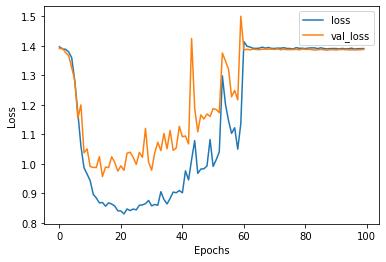

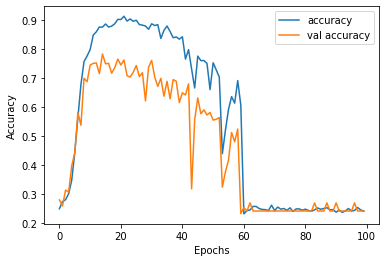

In [14]:
plot_learning_curve(history)

In [ ]:
def prediction(model,tokenizer,input_string):
    
    padded_tokens = tokenizer(
    text=[input_string],
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
    
    my_prediction = model.predict(padded_tokens['input_ids'])
    print(my_prediction)
    conversion_dict = {0:'joy',1:'fear',2:'anger',3:'sadness'}
    
    return conversion_dict[np.argmax(my_prediction)]